# TOP vs UKB (without medicaments)

This notebook trains the models without the medicaments. These models are then compared to the models separately trained on the UK Biobank data.

In [1]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
)

from xgb_model import train_model, test_model

from utils import (
    load_params,
    prepare_data,
    censor_after,
    produce_stats,
    provide_stratified_bootstap_sample_indices,
    get_confidence_interval,
)

random.seed(99)
np.random.seed(99)

FRACTURES = ["vertebral_fracture", "hip_fracture", "any_fracture"]

# Define times at which to measure AUC (every year)
TIMES = np.arange(12, 95, 12)
TIME_TO_EVALUATE = 24

In [2]:
# Define features to use for validation on UK Biobank
FEATURES = [
    "age", "bmi", "hrt", "decrease_in_height", "ankylosing_spondylitis", "copd",
    "hyperpara", "type_1_diabetes", "rheumatoid_arthritis", "number_of_falls",
    "early_menopause", "nicotin", "alcohol", "gastrointestinal_disease",
    "tscore_ls", "tscore_neck", "tscore_totalHip", "tbs_ls", "min_tscore",
    "recent_fracture", "previous_fracture"
]

In [3]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])
test_data = test_data.dropna()

## Train Cox PH model

vertebral
------------- train -------------
Harrels C-Index (Global): 0.6898
Harrels C-Index (at t=24): 0.6861
Unos C-Index: 0.6843
------------- valid -------------
Harrels C-Index (Global): 0.6634
Harrels C-Index (at t=24): 0.659
Unos C-Index: 0.6571
AUC at 2y: 0.6693
Mean AUC: 0.6944

hip
------------- train -------------
Harrels C-Index (Global): 0.7268
Harrels C-Index (at t=24): 0.7129
Unos C-Index: 0.7156
------------- valid -------------
Harrels C-Index (Global): 0.6702
Harrels C-Index (at t=24): 0.669
Unos C-Index: 0.6722
AUC at 2y: 0.68
Mean AUC: 0.6813

any
------------- train -------------
Harrels C-Index (Global): 0.6232
Harrels C-Index (at t=24): 0.6167
Unos C-Index: 0.6162
------------- valid -------------
Harrels C-Index (Global): 0.6197
Harrels C-Index (at t=24): 0.6167
Unos C-Index: 0.6153
AUC at 2y: 0.6278
Mean AUC: 0.6479



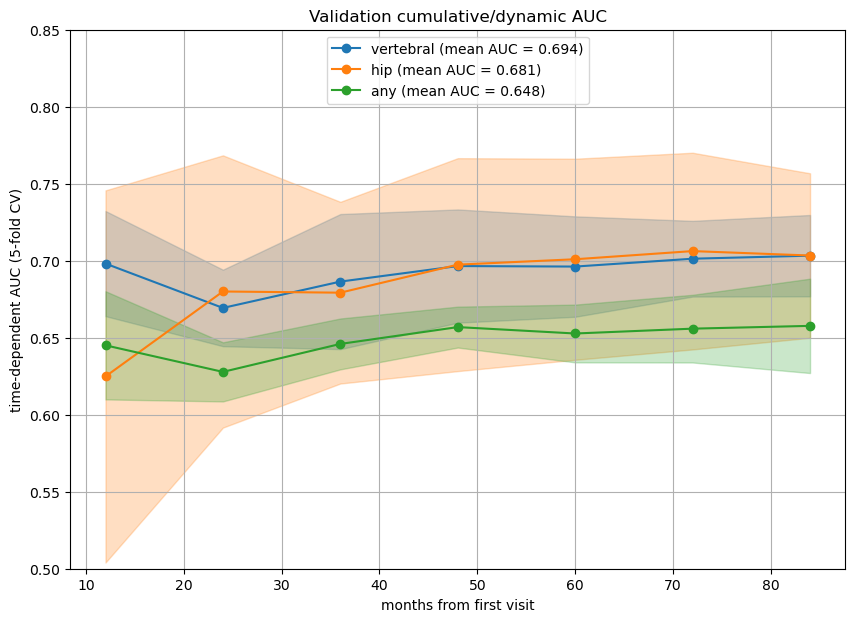

In [4]:
# Setup dataframe to store statistics in
multi_index = pd.MultiIndex.from_tuples([(x, y) for x in ["vertebral", "hip", "any"] for y in ["train", "valid", "test"]])
df_stats = pd.DataFrame([], index=multi_index, columns=["harrel_global", "harrel_2y", "uno_2y", "auc_2y", "auc_mean"])

cv = 5
kf = StratifiedKFold(n_splits=cv)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    c_index_scores = {"train": {}, "valid": {}}
    auc_scores = {}
    for cv_index, (train_index, validation_index) in enumerate(kf.split(train_data, train_data.loc[:,"any_right_censored"])):
        # Split train and validation set
        train_prepped = prepare_data(train_data.loc[train_index,:], fx_type, only_first_visits=True, feature_list=FEATURES, standardize=True)
        X_train, y_train, scaler = train_prepped["X"], train_prepped["y"], train_prepped["scaler"]
        valid_prepped = prepare_data(train_data.loc[validation_index,:], fx_type, scaler, only_first_visits=True, feature_list=FEATURES, standardize=True)
        X_valid, y_valid = valid_prepped["X"], valid_prepped["y"]
        
        # Train model
        model = CoxPHSurvivalAnalysis()
        model.fit(X_train, y_train)
        
        for tv in ["train", "valid"]:
            if tv == "train":
                X, y = X_train, y_train
            else:
                X, y = X_valid, y_valid
                
            # Compute cumlutaive hazard functions over time for each patient
            # They can be understood as our risk scores at a specific time
            chf_funcs = model.predict_cumulative_hazard_function(X, return_array=False)
            risk_scores = np.row_stack([chf(TIMES) for chf in chf_funcs])
            
            # Censor events after time t
            y_censored = censor_after(y, TIME_TO_EVALUATE)
            
            # Compute Harrel's and Uno's C-Index
            c_index_harrel_glob = model.score(X, y)
            c_index_harrel, _, _, _, _ = concordance_index_censored(y_censored["Event_observed"], y_censored["Survival_in_months"], [chf(TIME_TO_EVALUATE) for chf in chf_funcs])
            c_index_uno, _, _, _, _ = concordance_index_ipcw(y_train, y_censored, [chf(TIME_TO_EVALUATE) for chf in chf_funcs])
            c_index_scores[tv].setdefault(f"{fx_type}_harrel_global", list()).append(c_index_harrel_glob)
            c_index_scores[tv].setdefault(f"{fx_type}_harrel", list()).append(c_index_harrel)
            c_index_scores[tv].setdefault(f"{fx_type}_uno", list()).append(c_index_uno)

        # Compute cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_train, y_valid, risk_scores, TIMES)
        auc_scores.setdefault(fx_type, list()).append(auc)
        auc_scores.setdefault(f"{fx_type}_mean", list()).append(mean_auc)
    
    # Print C-Index Scores
    df_stats = produce_stats(df_stats, c_index_scores, auc_scores, t=24)
    
    # Plot the cumulative/dynamic AUC scores
    ax.plot(TIMES, np.mean(auc_scores[fx_type], axis=0), "o-", label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores[f"{fx_type}_mean"])))
    yerr_neg = np.mean(auc_scores[fx_type], axis=0) - np.std(auc_scores[fx_type], axis=0)
    yerr_pos = np.mean(auc_scores[fx_type], axis=0) + np.std(auc_scores[fx_type], axis=0)
    ax.fill_between(TIMES, yerr_neg, yerr_pos, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Validation cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC (5-fold CV)")
    ax.legend(loc="upper center")
    ax.grid(True)
    print()

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.6779, 'harrel_2y': 0.6825, 'uno_2y': {'c-index': 0.68, 'lower': 0.632, 'upper': 0.727}, 'auc': 0.6969, 'auc_mean': 0.7067}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.642, 'harrel_2y': 0.632, 'uno_2y': {'c-index': 0.6329, 'lower': 0.547, 'upper': 0.721}, 'auc': 0.6429, 'auc_mean': 0.6739}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': 0.6234, 'harrel_2y': 0.623, 'uno_2y': {'c-index': 0.6241, 'lower': 0.59, 'upper': 0.656}, 'auc': 0.643, 'auc_mean': 0.6576}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.6898    0.6861  0.6843     NaN      NaN
          valid        0.6634     0.659  0.6571  0.6693   0.6944
          test         0.6779    0.6825    0.68  0.6969   0.7067
hip       train        0.7268    0.7129  0.7156     NaN      NaN
          valid        0.6702     0.669  0.6722    0.68   0.6813
          test          0.642     0.632  0.6329  0.6429   0.6739
any       train        0.6232    0.6167  0.6162     NaN      NaN
          valid        0.6197    0.6167  0.6153  0.6278   0.6479
          test         0.6234     0.623  0.6241   0.643   0.6576

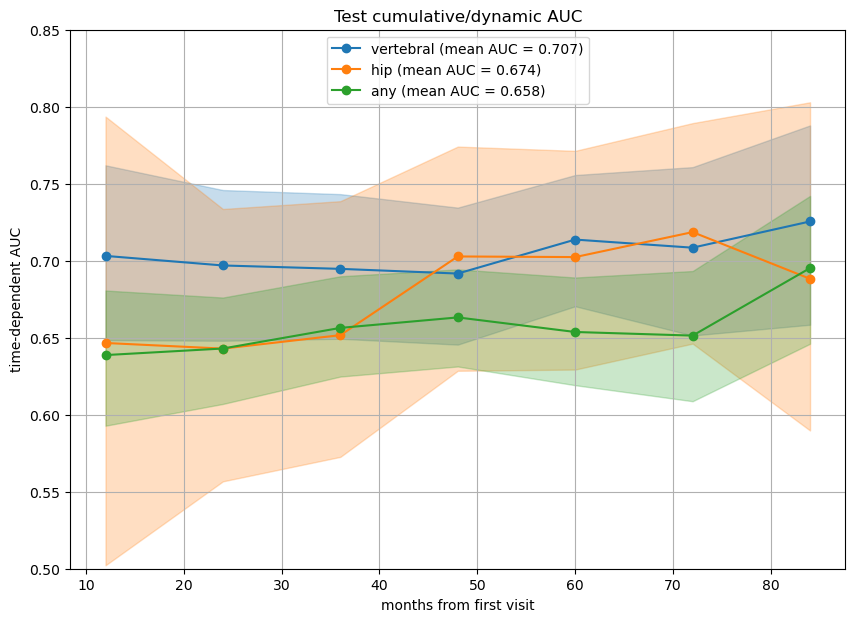

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
test_scores = {}
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    train_prepped = prepare_data(train_data, fx_type, only_first_visits=True, feature_list=FEATURES, standardize=True)
    X_train, y_train, scaler = train_prepped["X"], train_prepped["y"], train_prepped["scaler"]
    
    model = CoxPHSurvivalAnalysis()
        
    # Train model
    model.fit(X_train, y_train)    
    
    # Save model and scaler
    pickle.dump(model, open(f"models/ukb/cox/{fx_type}.pkl", "wb"))
    if i == 0:
        pickle.dump(scaler, open(f"models/ukb/cox/scaler.pkl", "wb"))
    
    c_index_scores = {"harrel_global": [], "harrel_2y": [], "uno_2y": []}
    auc_scores = {"auc": [], "mean_auc": []}
    # Bootstrap test set with 1000 samples
    n_bootstrap = 1000
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = test_data.copy()
        
        # Create bootstrap sample
        np.random.seed(bootsrap_idx)
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
        bs_sample = bs_sample.loc[bs_index_list_stratified , :]

        test_prepped = prepare_data(bs_sample, fx_type, scaler, only_first_visits=True, feature_list=FEATURES, standardize=True)
        X_test, y_test = test_prepped["X"], test_prepped["y"]
                
        # Compute cumlutaive hazard functions over time for each patient
        # They can be understood as our risk scores at a specific time
        chf_funcs = model.predict_cumulative_hazard_function(X_test)
        risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
    
        # Censor events after time t
        y_test_censored = censor_after(y_test, TIME_TO_EVALUATE)
            
        # Compute Harrel's and Uno's C-Index
        c_index_harrel_glob = model.score(X_test, y_test)
        c_index_harrel, _, _, _, _ = concordance_index_censored(y_test_censored["Event_observed"], y_test_censored["Survival_in_months"], risk_scores)
        c_index_uno, _, _, _, _ = concordance_index_ipcw(y_test, y_test_censored, risk_scores)
        c_index_scores["harrel_global"].append(c_index_harrel_glob)
        c_index_scores["harrel_2y"].append(c_index_harrel)
        c_index_scores["uno_2y"].append(c_index_uno)
        
        # Compute and plot cululative/dynamic AUC
        auc, mean_auc = cumulative_dynamic_auc(y_test, y_test, risk_scores, TIMES)
        auc_scores["auc"].append(auc)
        auc_scores["mean_auc"].append(mean_auc)
    
    # 95% confidence intervals
    uno_lower, uno_upper = get_confidence_interval(c_index_scores["uno_2y"], alpha=0.95, decimals=3)
    test_scores[fx_type] = {
        "harrel_global": round(np.mean(c_index_scores["harrel_global"]), 4),
        "harrel_2y": round(np.mean(c_index_scores["harrel_2y"]), 4),
        "uno_2y": {
            "c-index": round(np.mean(c_index_scores['uno_2y']), 4),
            "lower": uno_lower,
            "upper": uno_upper,
        },
        "auc": round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4),
        "auc_mean": round(np.mean(auc_scores["mean_auc"]), 4)
    }
    print(test_scores[fx_type])
    
    # Compute and plot cululative/dynamic AUC
    ax.plot(TIMES, np.mean(auc_scores["auc"], axis=0), "o-", color=f'C{i}', label="{} (mean AUC = {:.3f})".format(fx_type, np.mean(auc_scores["mean_auc"])))
    
    # 95% confidence intervals
    lower, upper = get_confidence_interval(auc_scores["auc"], alpha=0.95, ax=0)
    ax.fill_between(TIMES, lower, upper, color=f'C{i}', alpha=0.25)
    
    ax.set_title("Test cumulative/dynamic AUC")
    ax.set_ylim(0.5, 0.85)
    ax.set_xlabel("months from first visit")
    ax.set_ylabel("time-dependent AUC")
    ax.legend(loc="upper center")
    ax.grid(True)
    
    # Add to df_stats
    df_stats.loc[(fx_type, "test"), "harrel_global"] = round(np.mean(c_index_scores["harrel_global"]), 4)
    df_stats.loc[(fx_type, "test"), "harrel_2y"] = round(np.mean(c_index_scores["harrel_2y"]), 4)
    df_stats.loc[(fx_type, "test"), "uno_2y"] = round(np.mean(c_index_scores['uno_2y']), 4)
    df_stats.loc[(fx_type, "test"), "auc_2y"] = round(np.mean(auc_scores["auc"], axis=0)[(TIME_TO_EVALUATE // 12) - 1], 4)
    df_stats.loc[(fx_type, "test"), "auc_mean"] = round(np.mean(auc_scores["mean_auc"]), 4)
    
    print()

# Save test scores
with open("results/without_medicaments/TOP/cox_test_scores.json", "w") as f:
    json.dump(test_scores, f)

df_stats

## Train XGBoost with AFT

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7447
Harrels C-Index (at t=24): 0.7469
Unos C-Index: 0.7456
------------- valid -------------
Harrels C-Index (Global): 0.6761
Harrels C-Index (at t=24): 0.6727
Unos C-Index: 0.6714
AUC at 2y: 0.6828
Mean AUC: 0.6973
hip
------------- train -------------
Harrels C-Index (Global): 0.7504
Harrels C-Index (at t=24): 0.7643
Unos C-Index: 0.7634
------------- valid -------------
Harrels C-Index (Global): 0.6935
Harrels C-Index (at t=24): 0.7032
Unos C-Index: 0.7044
AUC at 2y: 0.7148
Mean AUC: 0.7085
any
------------- train -------------
Harrels C-Index (Global): 0.6729
Harrels C-Index (at t=24): 0.6802
Unos C-Index: 0.6787
------------- valid -------------
Harrels C-Index (Global): 0.6236
Harrels C-Index (at t=24): 0.6243
Unos C-Index: 0.623
AUC at 2y: 0.6346
Mean AUC: 0.6418



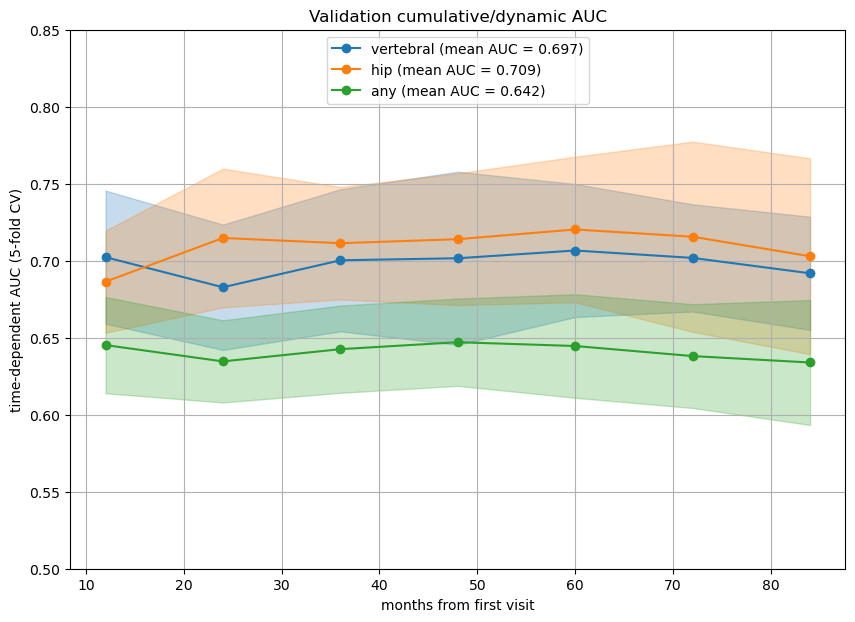

In [6]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

best_params = load_params(model="aft", constraints=True)
df_stats = train_model(
    train_data, 
    best_params, 
    t=TIME_TO_EVALUATE, 
    times=TIMES,
    model_type="aft",
    calibrated=False,
    fractures=FRACTURES,
    features=FEATURES,
    )

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6732, 'lower': 0.638, 'upper': 0.709}, 'harrel_2y': 0.6898, 'uno_2y': {'c-index': 0.6884, 'lower': 0.645, 'upper': 0.734}, 'auc': 0.7048, 'auc_mean': 0.6908}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.693, 'lower': 0.633, 'upper': 0.751}, 'harrel_2y': 0.685, 'uno_2y': {'c-index': 0.6908, 'lower': 0.62, 'upper': 0.762}, 'auc': 0.7038, 'auc_mean': 0.7305}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6182, 'lower': 0.595, 'upper': 0.643}, 'harrel_2y': 0.6206, 'uno_2y': {'c-index': 0.6225, 'lower': 0.593, 'upper': 0.653}, 'auc': 0.6394, 'auc_mean': 0.6379}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7447    0.7469  0.7456     NaN      NaN
          valid        0.6761    0.6727  0.6714  0.6828   0.6973
          test         0.6732    0.6898  0.6884  0.7048   0.6908
hip       train        0.7504    0.7643  0.7634     NaN      NaN
          valid        0.6935    0.7032  0.7044  0.7148   0.7085
          test          0.693     0.685  0.6908  0.7038   0.7305
any       train        0.6729    0.6802  0.6787     NaN      NaN
          valid        0.6236    0.6243   0.623  0.6346   0.6418
          test         0.6182    0.6206  0.6225  0.6394   0.6379

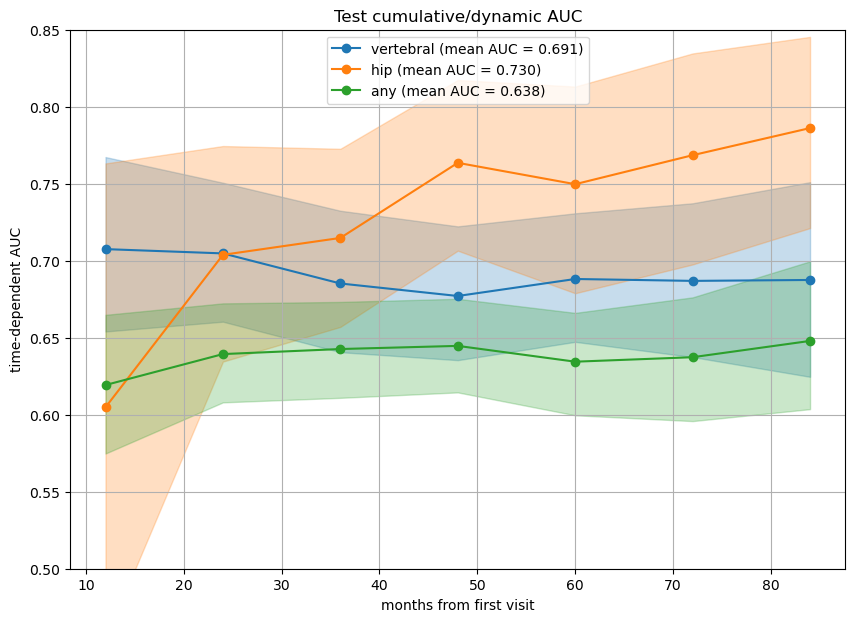

In [8]:
best_params = load_params(model="aft", constraints=True)
results = test_model(
    train_data, 
    test_data, 
    best_params, 
    TIME_TO_EVALUATE, 
    TIMES, 
    "aft_mono", 
    df_stats, 
    calibrated=False,
    save_model_path="models/ukb",
    save_results_path="results/without_medicaments/TOP",
    fractures=FRACTURES,
    features=FEATURES,
)
results["stats"]

## Train XGBoost with Cox

vertebral
------------- train -------------
Harrels C-Index (Global): 0.7758
Harrels C-Index (at t=24): 0.7728
Unos C-Index: 0.7721
------------- valid -------------
Harrels C-Index (Global): 0.6848
Harrels C-Index (at t=24): 0.6776
Unos C-Index: 0.6769
AUC at 2y: 0.6884
Mean AUC: 0.7101
hip
------------- train -------------
Harrels C-Index (Global): 0.8288
Harrels C-Index (at t=24): 0.8316
Unos C-Index: 0.8318
------------- valid -------------
Harrels C-Index (Global): 0.699
Harrels C-Index (at t=24): 0.7063
Unos C-Index: 0.7068
AUC at 2y: 0.7149
Mean AUC: 0.7101
any
------------- train -------------
Harrels C-Index (Global): 0.6878
Harrels C-Index (at t=24): 0.6877
Unos C-Index: 0.6871
------------- valid -------------
Harrels C-Index (Global): 0.6221
Harrels C-Index (at t=24): 0.6224
Unos C-Index: 0.6215
AUC at 2y: 0.6328
Mean AUC: 0.6437



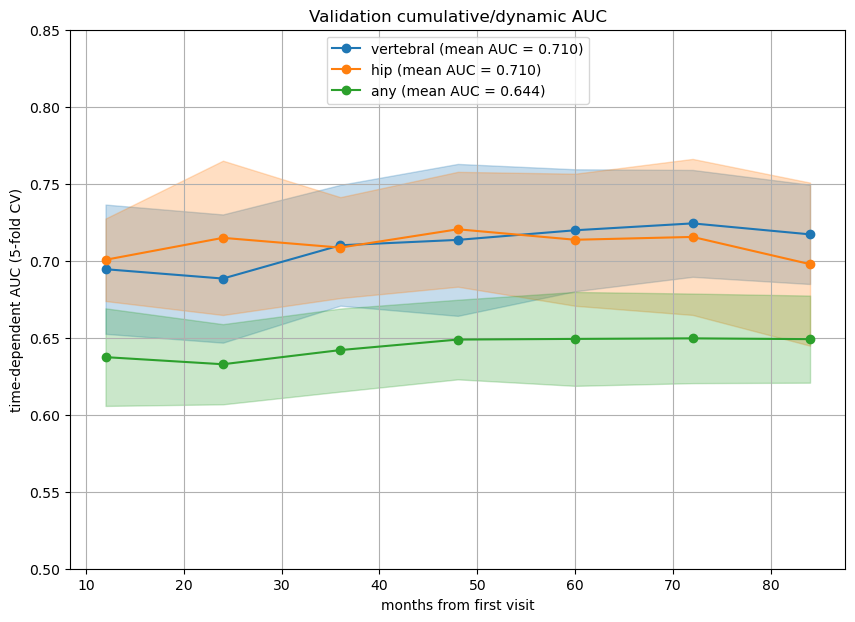

In [9]:
# Load data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])
test_data = test_data.dropna()

best_params = load_params(model="cox", constraints=True)
df_stats = train_model(
    train_data, 
    best_params, 
    t=TIME_TO_EVALUATE, 
    times=TIMES,
    model_type="cox",
    fractures=FRACTURES,
    features=FEATURES,
    )

vertebral


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6725, 'lower': 0.637, 'upper': 0.708}, 'harrel_2y': 0.683, 'uno_2y': {'c-index': 0.6812, 'lower': 0.639, 'upper': 0.724}, 'auc': 0.698, 'auc_mean': 0.6995}

hip


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6932, 'lower': 0.634, 'upper': 0.753}, 'harrel_2y': 0.6819, 'uno_2y': {'c-index': 0.6856, 'lower': 0.611, 'upper': 0.763}, 'auc': 0.6973, 'auc_mean': 0.731}

any


  0%|          | 0/1000 [00:00<?, ?it/s]

{'harrel_global': {'c-index': 0.6104, 'lower': 0.583, 'upper': 0.636}, 'harrel_2y': 0.606, 'uno_2y': {'c-index': 0.6073, 'lower': 0.574, 'upper': 0.639}, 'auc': 0.6239, 'auc_mean': 0.6369}



harrel_global harrel_2y  uno_2y  auc_2y auc_mean
vertebral train        0.7758    0.7728  0.7721     NaN      NaN
          valid        0.6848    0.6776  0.6769  0.6884   0.7101
          test         0.6725     0.683  0.6812   0.698   0.6995
hip       train        0.8288    0.8316  0.8318     NaN      NaN
          valid         0.699    0.7063  0.7068  0.7149   0.7101
          test         0.6932    0.6819  0.6856  0.6973    0.731
any       train        0.6878    0.6877  0.6871     NaN      NaN
          valid        0.6221    0.6224  0.6215  0.6328   0.6437
          test         0.6104     0.606  0.6073  0.6239   0.6369

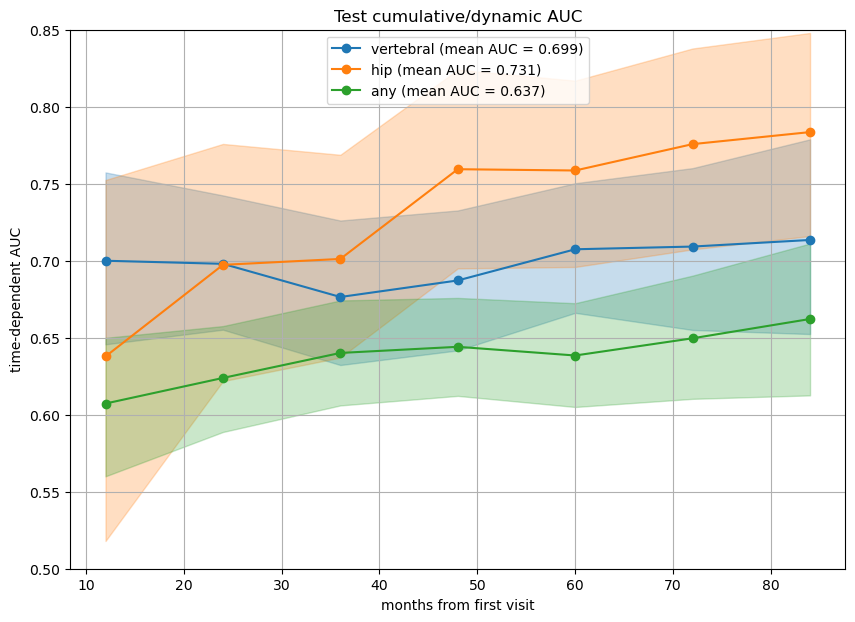

In [10]:
best_params = load_params(model="cox", constraints=True)
summary = test_model(
    train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, "cox_mono", df_stats,
    save_model_path="models/ukb",
    save_results_path="results/without_medicaments/TOP",
    fractures=FRACTURES,
    features=FEATURES,
)
summary["stats"]

## Only export StandardScaler for UKB

In [ ]:
# Load data
train_data = pd.read_csv("../../../data/final/train/train.csv", parse_dates=["date"])
test_data = pd.read_csv("../../../data/final/test/test.csv", parse_dates=["date"])

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

data = train_data[train_data["postmenopausal"] == 1]
data = data.dropna()
data["min_tscore"] = data[["tscore_ls", "tscore_totalHip", "tscore_neck"]].min(axis=1)

# Standardize values
continuous_variables = [
    "bmi", "age", "tscore_ls", "tscore_neck", "tscore_totalHip", 
    "min_tscore", "tbs_ls", "recent_fracture", "previous_fracture"
]
scaler = StandardScaler()
scaler.fit(data[continuous_variables])
pickle.dump(scaler, open(f"models/ukb/cox/scaler2.pkl", "wb"))

## Plot results from UKB

In [2]:
# Read test results
df_results = pd.DataFrame()
models = ["cox", "xgb_aft_mono", "xgb_cox_mono"]
for model_type in models:
    with open(f"results/without_medicaments/TOP/{model_type}_test_scores.json", "r") as f:
        test_results = json.load(f)
        for fx_type in test_results.keys():
            df_results.loc[fx_type, model_type] = test_results[fx_type]["uno_2y"]["c-index"]
            df_results.loc[fx_type, f"{model_type}_lower"] = test_results[fx_type]["uno_2y"]["lower"]
            df_results.loc[fx_type, f"{model_type}_upper"] = test_results[fx_type]["uno_2y"]["upper"]
df_results

,cox,cox_lower,cox_upper,xgb_aft_mono,xgb_aft_mono_lower,xgb_aft_mono_upper,xgb_cox_mono,xgb_cox_mono_lower,xgb_cox_mono_upper
vertebral,0.6800,0.632,0.727,0.6884,0.645,0.734,0.6812,0.639,0.724
hip,0.6329,0.547,0.721,0.6908,0.620,0.762,0.6856,0.611,0.763
any,0.6241,0.590,0.656,0.6225,0.593,0.653,0.6073,0.574,0.639


In [3]:
df_results[models]

,cox,xgb_aft_mono,xgb_cox_mono
vertebral,0.6800,0.6884,0.6812
hip,0.6329,0.6908,0.6856
any,0.6241,0.6225,0.6073


In [4]:
# Expected Shape (3 (model_type), 2 (lower+upper), 4 (fx_types))
errors = []
for model_type in models:
    lower_and_upper = []
    for fx_type in df_results.index:
        c_index = df_results.loc[fx_type, model_type]
        lower = df_results.loc[fx_type, f"{model_type}_lower"]
        upper = df_results.loc[fx_type, f"{model_type}_upper"]
        lower_and_upper.append([c_index - lower, upper - c_index])
    errors.append(np.array(lower_and_upper).T)
errors = np.array(errors)
print(errors.shape)
errors

(3, 2, 3)


array([[[0.048 , 0.0859, 0.0341],
        [0.047 , 0.0881, 0.0319]],

       [[0.0434, 0.0708, 0.0295],
        [0.0456, 0.0712, 0.0305]],

       [[0.0422, 0.0746, 0.0333],
        [0.0428, 0.0774, 0.0317]]])

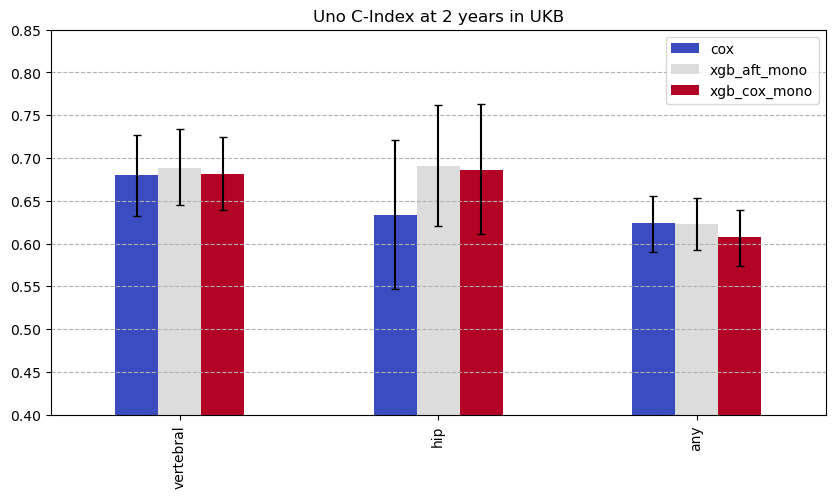

In [5]:
_, ax = plt.subplots(figsize=(10, 5))
df_results[models].plot(
    kind="bar", 
    title="Uno C-Index at 2 years in UKB", 
    ylim=(0.4, 0.85),
    yerr=errors,
    capsize=3,
    colormap="coolwarm",
    ax=ax
)
ax.grid(axis="y", linestyle="--")

In [6]:
# Read results from ukb
ukb_results = pd.read_csv("results/without_medicaments/UKB/results.csv", index_col=0)
ukb_results

,cox,cox_lower,cox_upper,xgb_aft_mono,xgb_aft_mono_lower,xgb_aft_mono_upper,xgb_cox_mono,xgb_cox_mono_lower,xgb_cox_mono_upper
vertebral,0.7077,0.570,0.831,0.7074,0.555,0.854,0.7392,0.582,0.863
hip,0.8251,0.701,0.943,0.7773,0.617,0.894,0.7512,0.636,0.880
any,0.5942,0.542,0.648,0.6328,0.581,0.688,0.6165,0.563,0.681


In [7]:
# Expected Shape (3 (model_type), 2 (lower+upper), 4 (fx_types))
errors_ukb = []
for model_type in models:
    lower_and_upper = []
    for fx_type in ukb_results.index:
        c_index = ukb_results.loc[fx_type, model_type]
        lower = ukb_results.loc[fx_type, f"{model_type}_lower"]
        upper = ukb_results.loc[fx_type, f"{model_type}_upper"]
        lower_and_upper.append([c_index - lower, upper - c_index])
    errors_ukb.append(np.array(lower_and_upper).T)
errors_ukb = np.array(errors_ukb)
print(errors_ukb.shape)
errors_ukb

(3, 2, 3)


array([[[0.1377, 0.1241, 0.0522],
        [0.1233, 0.1179, 0.0538]],

       [[0.1524, 0.1603, 0.0518],
        [0.1466, 0.1167, 0.0552]],

       [[0.1572, 0.1152, 0.0535],
        [0.1238, 0.1288, 0.0645]]])

In [15]:
df_results["dataset"] = "TOP"
ukb_results["dataset"] = "UKB"
df_results_merged = pd.concat([df_results, ukb_results])
df_results_merged = df_results_merged.reset_index()
df_results_merged = df_results_merged.set_index(["index", "dataset"])
df_results_merged = df_results_merged.sort_index(ascending=False, level=0)
df_results_merged

cox  cox_lower  cox_upper  xgb_aft_mono  \
index     dataset                                               
vertebral UKB      0.7077      0.570      0.831        0.7074   
          TOP      0.6800      0.632      0.727        0.6884   
hip       UKB      0.8251      0.701      0.943        0.7773   
          TOP      0.6329      0.547      0.721        0.6908   
any       UKB      0.5942      0.542      0.648        0.6328   
          TOP      0.6241      0.590      0.656        0.6225   

                   xgb_aft_mono_lower  xgb_aft_mono_upper  xgb_cox_mono  \
index     dataset                                                         
vertebral UKB                   0.555               0.854        0.7392   
          TOP                   0.645               0.734        0.6812   
hip       UKB                   0.617               0.894        0.7512   
          TOP                   0.620               0.762        0.6856   
any       UKB                   0.581               0.688        0.6165   
          TOP                   0.593               0.653        0.6073   

                   xgb_cox_mono_lower  xgb_cox_mono_upper  
index     dataset                                          
vertebral UKB                   0.582               0.863  
          TOP                   0.639               0.724  
hip       UKB                   0.636               0.880  
          TOP                   0.611               0.763  
any       UKB                   0.563               0.681  
          TOP                   0.574               0.639

In [16]:
# Merge xgb_aft and xgb_cox into xgb by including the best of both
best_of_both = [
    (("vertebral", "UKB"), "cox"),
    (("vertebral", "TOP"), "aft"),
    (("hip", "UKB"), "aft"),
    (("hip", "TOP"), "aft"),
    (("any", "UKB"), "aft"),
    (("any", "TOP"), "aft"),
]
for fx_dataset, best in best_of_both:
    print(fx_dataset)
    print(best)
    df_results_merged.loc[fx_dataset, "xgb"] = df_results_merged.loc[fx_dataset, f"xgb_{best}_mono"]
    df_results_merged.loc[fx_dataset, "xgb_lower"] = df_results_merged.loc[fx_dataset, f"xgb_{best}_mono_lower"]
    df_results_merged.loc[fx_dataset, "xgb_upper"] = df_results_merged.loc[fx_dataset, f"xgb_{best}_mono_upper"]

df_results_merged

('vertebral', 'UKB')
cox
('vertebral', 'TOP')
aft
('hip', 'UKB')
aft
('hip', 'TOP')
aft
('any', 'UKB')
aft
('any', 'TOP')
aft


cox  cox_lower  cox_upper  xgb_aft_mono  \
index     dataset                                               
vertebral UKB      0.7077      0.570      0.831        0.7074   
          TOP      0.6800      0.632      0.727        0.6884   
hip       UKB      0.8251      0.701      0.943        0.7773   
          TOP      0.6329      0.547      0.721        0.6908   
any       UKB      0.5942      0.542      0.648        0.6328   
          TOP      0.6241      0.590      0.656        0.6225   

                   xgb_aft_mono_lower  xgb_aft_mono_upper  xgb_cox_mono  \
index     dataset                                                         
vertebral UKB                   0.555               0.854        0.7392   
          TOP                   0.645               0.734        0.6812   
hip       UKB                   0.617               0.894        0.7512   
          TOP                   0.620               0.762        0.6856   
any       UKB                   0.581               0.688        0.6165   
          TOP                   0.593               0.653        0.6073   

                   xgb_cox_mono_lower  xgb_cox_mono_upper     xgb  xgb_lower  \
index     dataset                                                              
vertebral UKB                   0.582               0.863  0.7392      0.582   
          TOP                   0.639               0.724  0.6884      0.645   
hip       UKB                   0.636               0.880  0.7773      0.617   
          TOP                   0.611               0.763  0.6908      0.620   
any       UKB                   0.563               0.681  0.6328      0.581   
          TOP                   0.574               0.639  0.6225      0.593   

                   xgb_upper  
index     dataset             
vertebral UKB          0.863  
          TOP          0.734  
hip       UKB          0.894  
          TOP          0.762  
any       UKB          0.688  
          TOP          0.653

In [17]:
# Expected Shape (2 (model_type), 2 (lower+upper), 6 (rows))
errors = []
for model_type in ["cox", "xgb"]:
    lower_and_upper = []
    for fx_type, dataset in df_results_merged.index:
        c_index = df_results_merged.loc[(fx_type, dataset), model_type]
        lower = df_results_merged.loc[(fx_type, dataset), f"{model_type}_lower"]
        upper = df_results_merged.loc[(fx_type, dataset), f"{model_type}_upper"]
        lower_and_upper.append([c_index - lower, upper - c_index])
    errors.append(np.array(lower_and_upper).T)
errors = np.array(errors)
print(errors.shape)
errors

(2, 2, 6)


array([[[0.1377, 0.048 , 0.1241, 0.0859, 0.0522, 0.0341],
        [0.1233, 0.047 , 0.1179, 0.0881, 0.0538, 0.0319]],

       [[0.1572, 0.0434, 0.1603, 0.0708, 0.0518, 0.0295],
        [0.1238, 0.0456, 0.1167, 0.0712, 0.0552, 0.0305]]])

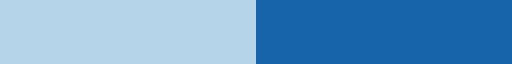

In [21]:
import matplotlib as mlp
import matplotlib.colors as mcol

lvTmp = np.linspace(0.3,0.8,2)
cmTmp = mlp.cm.Blues(lvTmp)
newCmap = mcol.ListedColormap(cmTmp)
newCmap

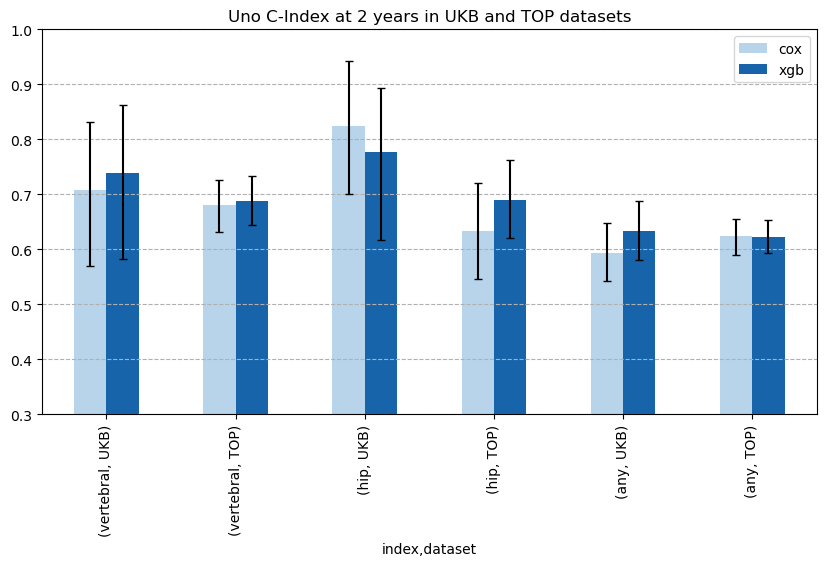

In [22]:
_, ax = plt.subplots(figsize=(10, 5))
df_results_merged[["cox", "xgb"]].plot(
    kind="bar", 
    title="Uno C-Index at 2 years in UKB and TOP datasets", 
    ylim=(0.3, 1.0),
    yerr=errors,
    capsize=3,
    colormap=newCmap,
    ax=ax
)
ax.grid(axis="y", linestyle="--")

In [25]:
df_results_merged.drop(["xgb_aft_mono", "xgb_aft_mono_lower", "xgb_aft_mono_upper", "xgb_cox_mono", "xgb_cox_mono_lower", "xgb_cox_mono_upper"], axis=1, inplace=True)
df_results_merged

cox  cox_lower  cox_upper     xgb  xgb_lower  xgb_upper
index     dataset                                                            
vertebral UKB      0.7077      0.570      0.831  0.7392      0.582      0.863
          TOP      0.6800      0.632      0.727  0.6884      0.645      0.734
hip       UKB      0.8251      0.701      0.943  0.7773      0.617      0.894
          TOP      0.6329      0.547      0.721  0.6908      0.620      0.762
any       UKB      0.5942      0.542      0.648  0.6328      0.581      0.688
          TOP      0.6241      0.590      0.656  0.6225      0.593      0.653

In [33]:
# rehsape the dataframe into the following shape
index = pd.MultiIndex.from_tuples([(x, y) for x in ["vertebral", "hip", "any"] for y in ["cox", "xgb"]])
columns = ["TOP", "TOP_lower", "TOP_upper", "UKB", "UKB_lower", "UKB_upper"]
df_results_reshaped = pd.DataFrame([], index=index, columns=columns)

# Fill the dataframe
for fx_type, dataset in df_results_merged.index:
    for model_type in ["cox", "xgb"]:
        df_results_reshaped.loc[(fx_type, model_type), f"{dataset}"] = df_results_merged.loc[(fx_type, dataset), model_type]
        df_results_reshaped.loc[(fx_type, model_type), f"{dataset}_lower"] = df_results_merged.loc[(fx_type, dataset), f"{model_type}_lower"]
        df_results_reshaped.loc[(fx_type, model_type), f"{dataset}_upper"] = df_results_merged.loc[(fx_type, dataset), f"{model_type}_upper"]
df_results_reshaped

TOP TOP_lower TOP_upper     UKB UKB_lower UKB_upper
vertebral cox    0.68     0.632     0.727  0.7077      0.57     0.831
          xgb  0.6884     0.645     0.734  0.7392     0.582     0.863
hip       cox  0.6329     0.547     0.721  0.8251     0.701     0.943
          xgb  0.6908      0.62     0.762  0.7773     0.617     0.894
any       cox  0.6241      0.59     0.656  0.5942     0.542     0.648
          xgb  0.6225     0.593     0.653  0.6328     0.581     0.688

In [34]:
# Expected Shape (2 (model_type), 2 (lower+upper), 6 (rows))
errors = []
for dataset in ["TOP", "UKB"]:
    lower_and_upper = []
    for fx_type, model_type in df_results_reshaped.index:
        c_index = df_results_reshaped.loc[(fx_type, model_type), dataset]
        lower = df_results_reshaped.loc[(fx_type, model_type), f"{dataset}_lower"]
        upper = df_results_reshaped.loc[(fx_type, model_type), f"{dataset}_upper"]
        lower_and_upper.append([c_index - lower, upper - c_index])
    errors.append(np.array(lower_and_upper).T)
errors = np.array(errors)
print(errors.shape)
errors

(2, 2, 6)


array([[[0.048 , 0.0434, 0.0859, 0.0708, 0.0341, 0.0295],
        [0.047 , 0.0456, 0.0881, 0.0712, 0.0319, 0.0305]],

       [[0.1377, 0.1572, 0.1241, 0.1603, 0.0522, 0.0518],
        [0.1233, 0.1238, 0.1179, 0.1167, 0.0538, 0.0552]]])

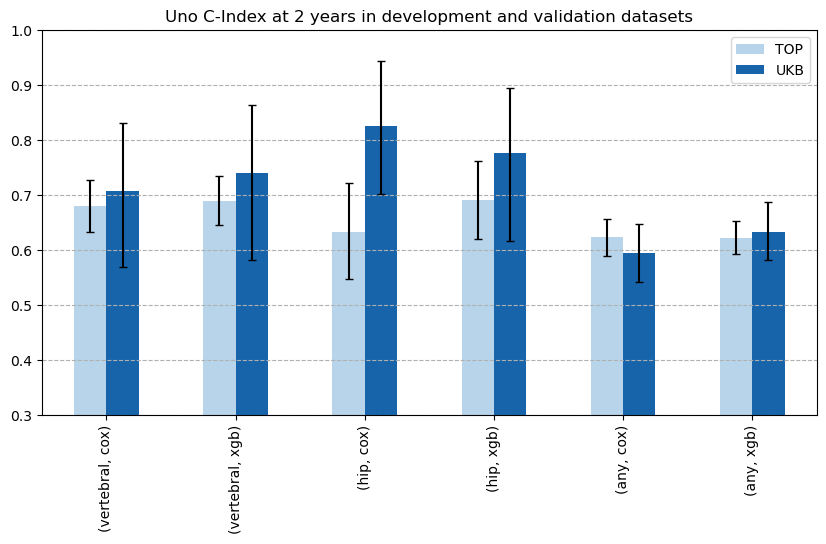

In [35]:
_, ax = plt.subplots(figsize=(10, 5))
df_results_reshaped[["TOP", "UKB"]].plot(
    kind="bar", 
    title="Uno C-Index at 2 years in development and validation datasets", 
    ylim=(0.3, 1.0),
    yerr=errors,
    capsize=3,
    colormap=newCmap,
    ax=ax
)
ax.grid(axis="y", linestyle="--")